In [1]:
import os
import pickle
from copy import deepcopy
from tqdm import tqdm
from datetime import date, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import optuna
from optuna.samplers import RandomSampler
import warnings
warnings.filterwarnings("ignore")
import multiprocessing
max_n_jobs = multiprocessing.cpu_count()
print(f"Maximum n_jobs you can use: {max_n_jobs}")

Maximum n_jobs you can use: 12


/Users/justpqa/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("NMXLNT_df.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
print(df["Location"].unique())
df.head()

['BAY MAU.csv' 'TU SON.csv' 'CAU NGA.csv' 'BTLVT.csv' 'YENSO.csv']


,level_0,datetime,flow_in,flow_out1,flow_out2,flow_out3,temp,ph,tss,do,...,Location_prev_12,minute_prev_12,sin_minute_prev_12,hour_prev_12,sin_hour_prev_12,day_prev_12,sin_day_prev_12,month_prev_12,sin_month_prev_12,abnormal
0,1,2024-01-01 12:05:00,312.09,4.70,4.30,17.61,27.52,7.15,7.60,NaN,...,BAY MAU.csv,5,0.500000,0,0.0,1,0.201299,1,0.5,False
1,2,2024-01-01 12:10:00,304.32,4.71,4.41,18.72,27.63,7.15,7.65,NaN,...,BAY MAU.csv,10,0.866025,0,0.0,1,0.201299,1,0.5,False
2,3,2024-01-01 12:15:00,304.53,4.62,4.58,18.97,27.63,7.16,7.56,NaN,...,BAY MAU.csv,15,1.000000,0,0.0,1,0.201299,1,0.5,False
3,4,2024-01-01 12:20:00,310.44,4.57,4.68,18.19,27.63,7.16,7.67,NaN,...,BAY MAU.csv,20,0.866025,0,0.0,1,0.201299,1,0.5,False
4,5,2024-01-01 12:25:00,308.93,132.15,113.86,525.37,27.63,7.17,7.69,NaN,...,BAY MAU.csv,25,0.500000,0,0.0,1,0.201299,1,0.5,False


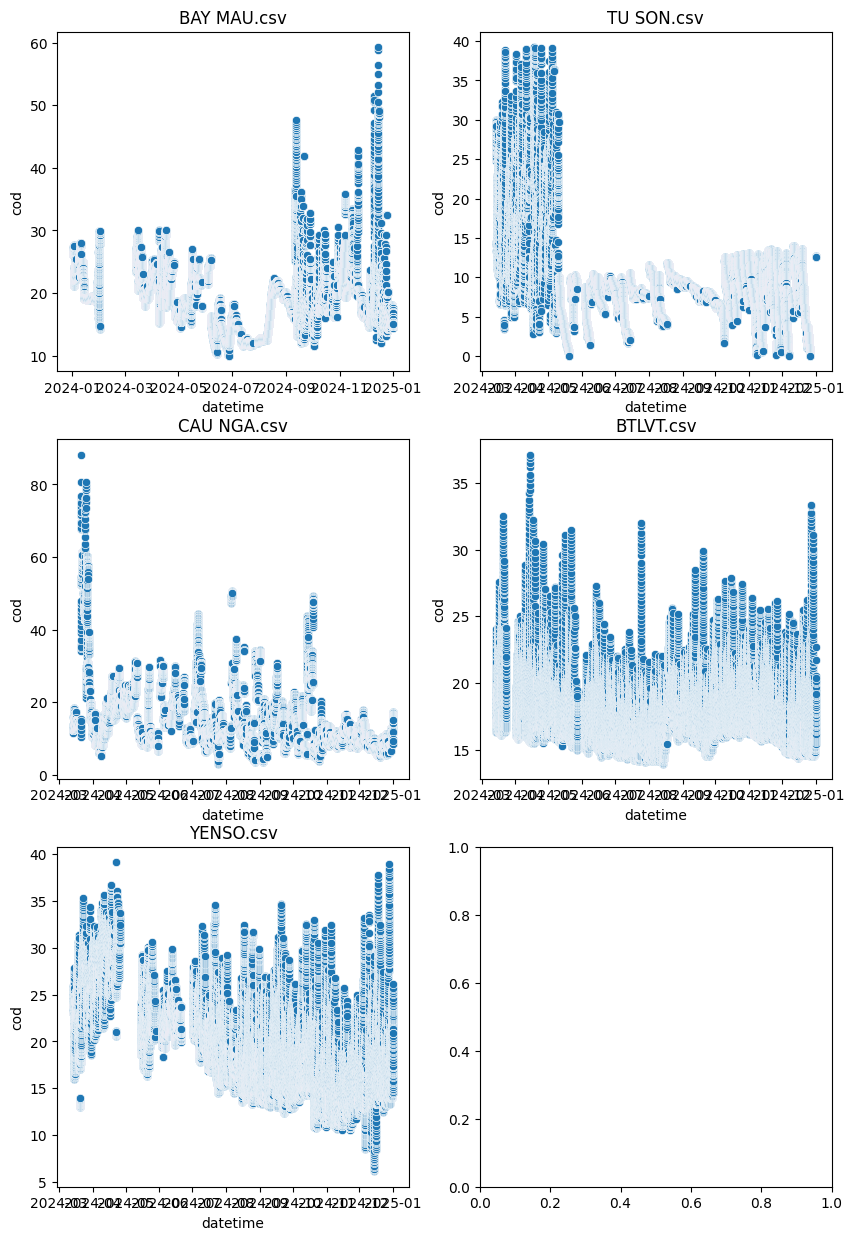

In [3]:
# try to plot cod against time in all data
fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (10, 15))
for inx, loc in enumerate(df["Location"].unique()):
    x, y = inx // 2, inx % 2
    sns.scatterplot(df[df["Location"] == loc], x = "datetime", y = "cod", ax = ax[x][y])
    ax[x][y].set_title(loc)
plt.show()

Make CV split & compare with baseline

In [4]:
def create_cv_split(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_val(df, features_used, cv = 5):
    X_train_arr = []
    X_val_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_val_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i - 1].reset_index().drop("index", axis = 1))
        val = deepcopy(df[df["datetime"].dt.month == start_month + i - 1].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / (train.shape[0] + test.shape[0]))
        X_train_arr.append(train[features_used])
        X_val_arr.append(val[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_val_arr.append(val["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_val_arr, X_test_arr, Y_train_arr, Y_val_arr, Y_test_arr

def create_cv_split_location(df, features_used, loc, cv = 5):
    df = df[df["Location"] == loc].reset_index().drop("index", axis = 1)
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_diff(df, features_used, time_diff = 4, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train[f"cod_diff_{time_diff}"])
        Y_test_arr.append(test[f"cod_diff_{time_diff}"])
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr

def create_cv_split_with_info(df, features_used, cv = 5):
    X_train_arr = []
    X_test_arr = []
    Y_train_arr = []
    Y_test_arr = []
    info_train_arr = []
    info_test_arr = []
    start_month = 13 - cv
    for i in range(cv):
        train = deepcopy(df[df["datetime"].dt.month < start_month + i].reset_index().drop("index", axis = 1))
        test = deepcopy(df[(df["datetime"].dt.month >= start_month + i) & (df["datetime"].dt.month < start_month + 1 + i)].reset_index().drop("index", axis = 1))
        #print(train.shape[0] / test.shape[0])
        X_train_arr.append(train[features_used])
        X_test_arr.append(test[features_used])
        Y_train_arr.append(train["cod"])
        Y_test_arr.append(test["cod"])
        info_train_arr.append(train[["datetime", "Location"]])
        info_test_arr.append((test[["datetime", "Location"]]))
    return X_train_arr, X_test_arr, Y_train_arr, Y_test_arr, info_train_arr, info_test_arr

Make the model and finetune

In [5]:
default_n_trees = 200
default_random_state = 101
# Finetuning XGBoost
def objective_xgboost(trial):
    params = {
        "n_estimators": default_n_trees,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log = True),
        "verbosity": 0,
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0, 1),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0, 1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0, 1),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "enable_categorical": True,
        "random_state": default_random_state
    }

    xgbr = XGBRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        xgbr.fit(X_train, Y_train)
        Y_pred = xgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_lightgbm(trial):
    params = {
        "n_estimators": default_n_trees,
        "verbosity": -1,
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 0, 1),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 100),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_state": default_random_state
    }

    lgbr = LGBMRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        lgbr.fit(X_train, Y_train)
        Y_pred = lgbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

def objective_catboost(trial):
    params = {
        "iterations": default_n_trees,
        "verbose": False,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 2, 600),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 100),
        "random_seed": default_random_state
    }

    cbr = CatBoostRegressor(**params)
    cv_rmse = 0

    for i in range(5):
        X_train, X_test = X_train_arr[i], X_test_arr[i]
        Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
        cbr.fit(X_train, Y_train)
        Y_pred = cbr.predict(X_test)
        cv_rmse += root_mean_squared_error(Y_test, Y_pred)
    
    return cv_rmse / 5

In [6]:
default_n_trials = 100
default_n_jobs = 4

def optimize_xgboost(study_name, storage_name, objective_function=objective_xgboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for XGBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction ='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSE:', study.best_value)
    return study.best_params

def optimize_lightgbm(study_name, storage_name, objective_function=objective_lightgbm, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for LightGBM")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best MSE:', study.best_value)
    return study.best_params

def optimize_catboost(study_name, storage_name, objective_function=objective_catboost, n_trials = default_n_trials, n_jobs = default_n_jobs):
    print("Conduct hyperparam opt for CatBoost")
    study = optuna.create_study(
        study_name = study_name,
        direction='minimize',
        storage = f"sqlite:///{storage_name}.db",
        sampler = RandomSampler(seed = 101),
        load_if_exists=True
    )
    study.optimize(objective_function, n_trials=n_trials, n_jobs=n_jobs)
    print('Best hyperparameters:', study.best_params)
    print('Best RMSLE:', study.best_value)
    return study.best_params

In [7]:
#### NOTE: All info about lags used will be saved here
lag_used = [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12]

In [ ]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
# features_used = [c for c in df.columns if "prev" in c and df[c].dtypes in ["int64", "float64"]]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# # baseline: using last k hours to predict
# baseline_score = 0
# for i in range(5):
#     baseline_score += np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2))
# baseline_score /= 5
# print(baseline_score)

# for loc in df["Location"].unique():
#     print(loc)
#     temp_df = deepcopy(df[df["Location"] == loc])
#     X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(temp_df, features_used)
#     for i in range(5):
#         print(i, np.sqrt(np.mean((Y_test_arr[i] - X_test_arr[i][f"cod_prev_4"])**2)))

# X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [9]:
best_params_xgboost = optimize_xgboost(
    f"xgboost_{default_random_state}_{default_n_trees}_study", 
    f"xgboost_{default_random_state}_{default_n_trees}_study"
)
# best is 2.85 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)
# best is 2.81 (with remove of abnormal cod)

Conduct hyperparam opt for XGBoost


[I 2025-06-09 17:14:02,379] Using an existing study with name 'xgboost_101_200_study' instead of creating a new one.
[I 2025-06-09 17:14:18,386] Trial 201 finished with value: 3.002182322325651 and parameters: {'max_depth': 7, 'learning_rate': 0.09306028045515197, 'subsample': 0.8047732379653305, 'colsample_bytree': 0.3003547303843014, 'colsample_bynode': 0.23591892018566352, 'colsample_bylevel': 0.5687072647691823, 'min_child_weight': 5, 'reg_alpha': 17.523407182279193, 'reg_lambda': 33.03799362292668, 'gamma': 0.3277297468242685}. Best is trial 27 with value: 2.8080443864589317.
[I 2025-06-09 17:14:18,443] Trial 200 finished with value: 3.1209138271356713 and parameters: {'max_depth': 7, 'learning_rate': 0.06726193340811615, 'subsample': 0.4552237236829888, 'colsample_bytree': 0.8044859048546423, 'colsample_bynode': 0.5448483477992835, 'colsample_bylevel': 0.06853557676777056, 'min_child_weight': 6, 'reg_alpha': 43.182294320948685, 'reg_lambda': 28.678548781457135, 'gamma': 0.2331981

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.04675727007049185, 'subsample': 0.661954679615826, 'colsample_bytree': 0.8981306675550518, 'colsample_bynode': 0.3615606190805486, 'colsample_bylevel': 0.9377959146819592, 'min_child_weight': 8, 'reg_alpha': 42.65362061250482, 'reg_lambda': 35.3000764535245, 'gamma': 0.4620576821669503}
Best RMSE: 2.8080443864589317


In [11]:
best_params_lightgbm = optimize_lightgbm(
    f"lightgbm_{default_random_state}_{default_n_trees}_study", 
    f"lightgbm_{default_random_state}_{default_n_trees}_study",
) 
# best is 2.96 (with remove of very high cod)
# best is 2.88 (without remove of very high cod)

[I 2025-06-09 18:19:59,326] Using an existing study with name 'lightgbm_101_200_study' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-06-09 18:20:11,947] Trial 202 finished with value: 2.923908432628745 and parameters: {'max_depth': 4, 'learning_rate': 0.018310957516318956, 'num_leaves': 985, 'subsample': 0.4554920491709204, 'colsample_bytree': 0.16342921381209854, 'min_child_weight': 0.19481069414379093, 'reg_alpha': 81.49246936603274, 'reg_lambda': 53.82583368276147}. Best is trial 35 with value: 2.7806213724386177.
[I 2025-06-09 18:20:12,599] Trial 200 finished with value: 2.9127672592652663 and parameters: {'max_depth': 4, 'learning_rate': 0.012314625674458863, 'num_leaves': 281, 'subsample': 0.3632628729387172, 'colsample_bytree': 0.20670885511418494, 'min_child_weight': 0.21015143310311213, 'reg_alpha': 49.74955150043534, 'reg_lambda': 1.508913999934114}. Best is trial 35 with value: 2.7806213724386177.
[I 2025-06-09 18:20:26,101] Trial 204 finished with value: 2.842778824290702 and parameters: {'max_depth': 4, 'learning_rate': 0.012052857280490223, 'num_leaves': 926, 'subsample': 0.5136110335538137, 'c

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.023050738544836052, 'num_leaves': 135, 'subsample': 0.8010996899581724, 'colsample_bytree': 0.8682680353286343, 'min_child_weight': 0.021257197218687907, 'reg_alpha': 43.804778401705455, 'reg_lambda': 96.86838020798793}
Best MSE: 2.7806213724386177


In [14]:
best_params_catboost = optimize_catboost(
    f"catboost_{default_random_state}_{default_n_trees}_study", 
    f"catboost_{default_random_state}_{default_n_trees}_study",
    objective_catboost
)
# best is this one, about 2.81 RMSE (with remove of very high cod)
# best is 2.859 (without remove of very high cod)

[I 2025-06-09 19:09:50,436] Using an existing study with name 'catboost_101_200_study' instead of creating a new one.


Conduct hyperparam opt for CatBoost


[I 2025-06-09 19:09:59,977] Trial 201 finished with value: 2.9727390422565367 and parameters: {'learning_rate': 0.02476974323147278, 'depth': 3, 'subsample': 0.8833457434192311, 'colsample_bylevel': 0.06765284486005138, 'min_data_in_leaf': 529, 'reg_lambda': 46.55794420980931}. Best is trial 55 with value: 2.793893612500858.
[I 2025-06-09 19:10:02,392] Trial 203 finished with value: 2.8209516563055645 and parameters: {'learning_rate': 0.07462741471027613, 'depth': 2, 'subsample': 0.5874532948469293, 'colsample_bylevel': 0.8189701975658072, 'min_data_in_leaf': 170, 'reg_lambda': 98.16560807556894}. Best is trial 55 with value: 2.793893612500858.
[I 2025-06-09 19:10:09,378] Trial 204 finished with value: 2.9077962652896274 and parameters: {'learning_rate': 0.026426799607534242, 'depth': 1, 'subsample': 0.5440720765888287, 'colsample_bylevel': 0.9478259026812857, 'min_data_in_leaf': 246, 'reg_lambda': 24.732043601108423}. Best is trial 55 with value: 2.793893612500858.
[I 2025-06-09 19:10

Best hyperparameters: {'learning_rate': 0.025483496841099778, 'depth': 8, 'subsample': 0.6341983242607909, 'colsample_bylevel': 0.8868720899309833, 'min_data_in_leaf': 170, 'reg_lambda': 23.743972111399902}
Best RMSLE: 2.792333231223161


Analyze the range of best params

In [9]:
def get_study_df(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    study_df = []
    for trial in study.trials:
        trial_dict = trial.params
        trial_dict["value"] = trial.value
        study_df.append(trial_dict)

    return pd.DataFrame(study_df)

In [10]:
def params_value_viz(study_df):
    nrows = (study_df.shape[1] - 1) // 3 + ((study_df.shape[1] - 1) % 3 > 0)
    fig, ax = plt.subplots(nrows = nrows, ncols = 3, figsize = (14, 5 * nrows))
    for inx, var in enumerate(study_df.columns):
        x, y = inx // 3, inx % 3
        if var != "value":
            sns.scatterplot(study_df, x = var, y = "value", ax = ax[x][y])
    plt.show()

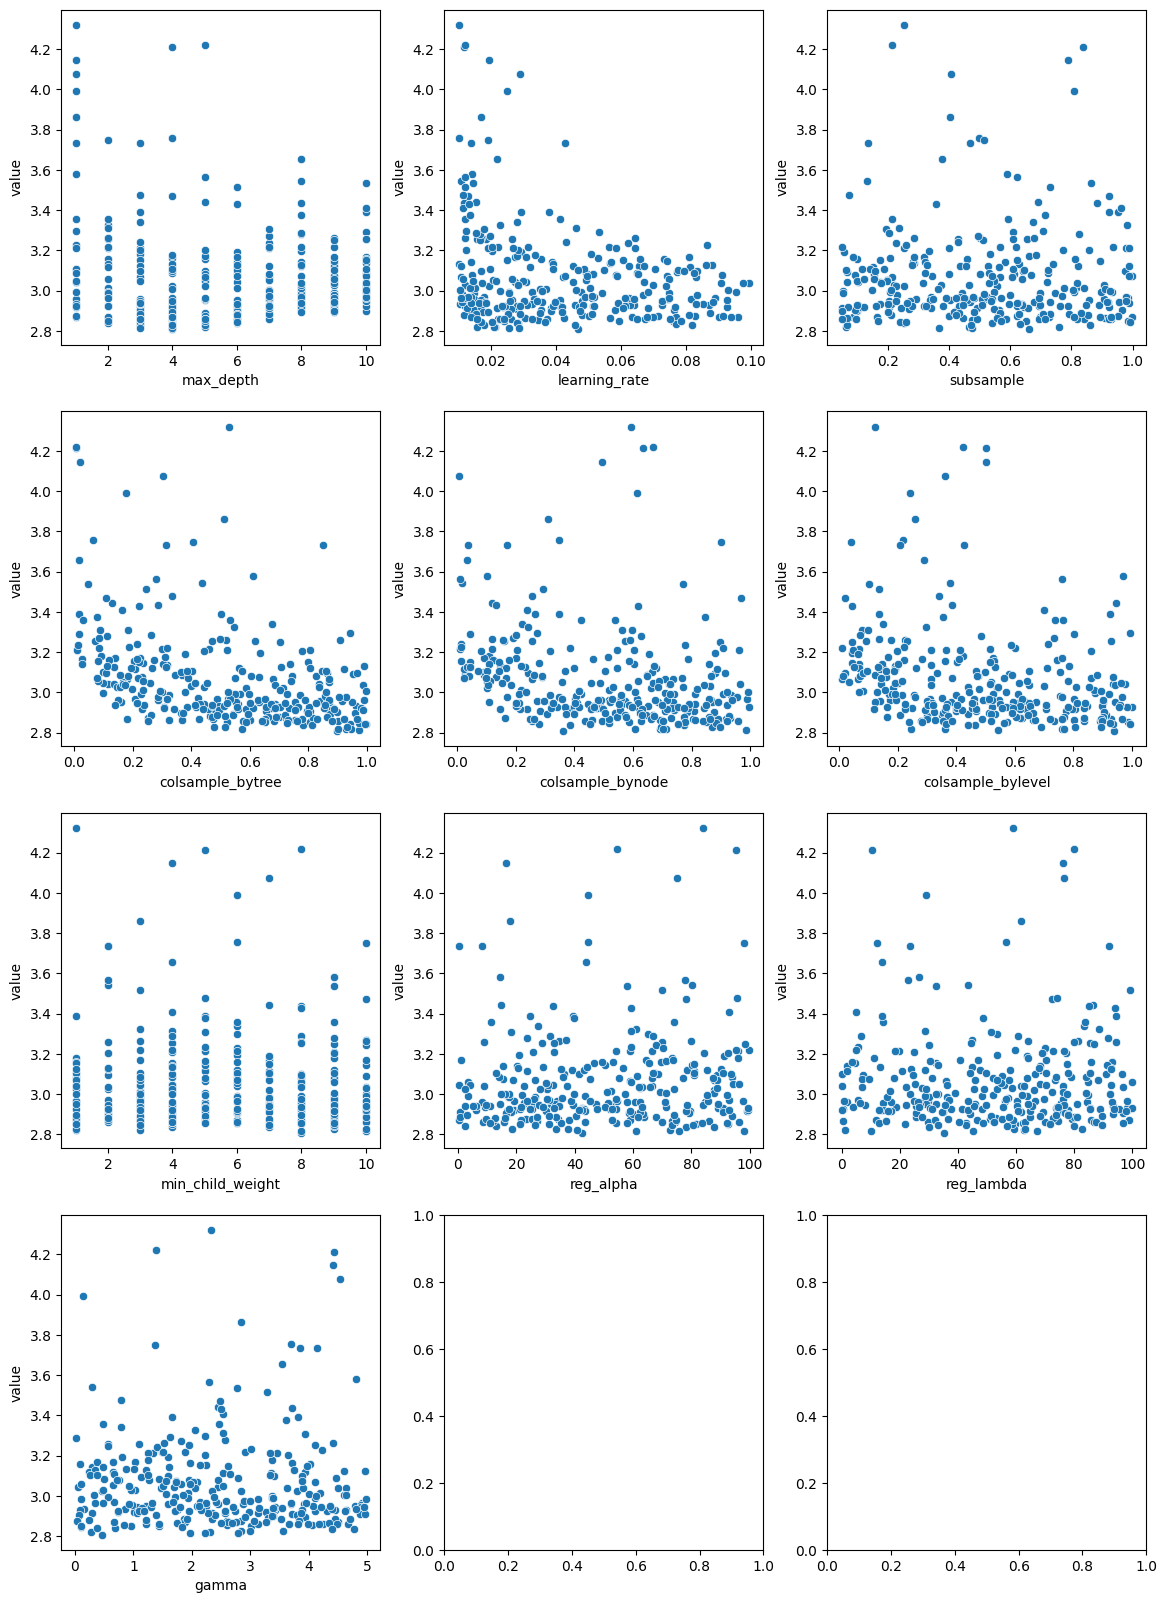

In [26]:
study_df = get_study_df("xgboost_101_200_study")
params_value_viz(study_df)

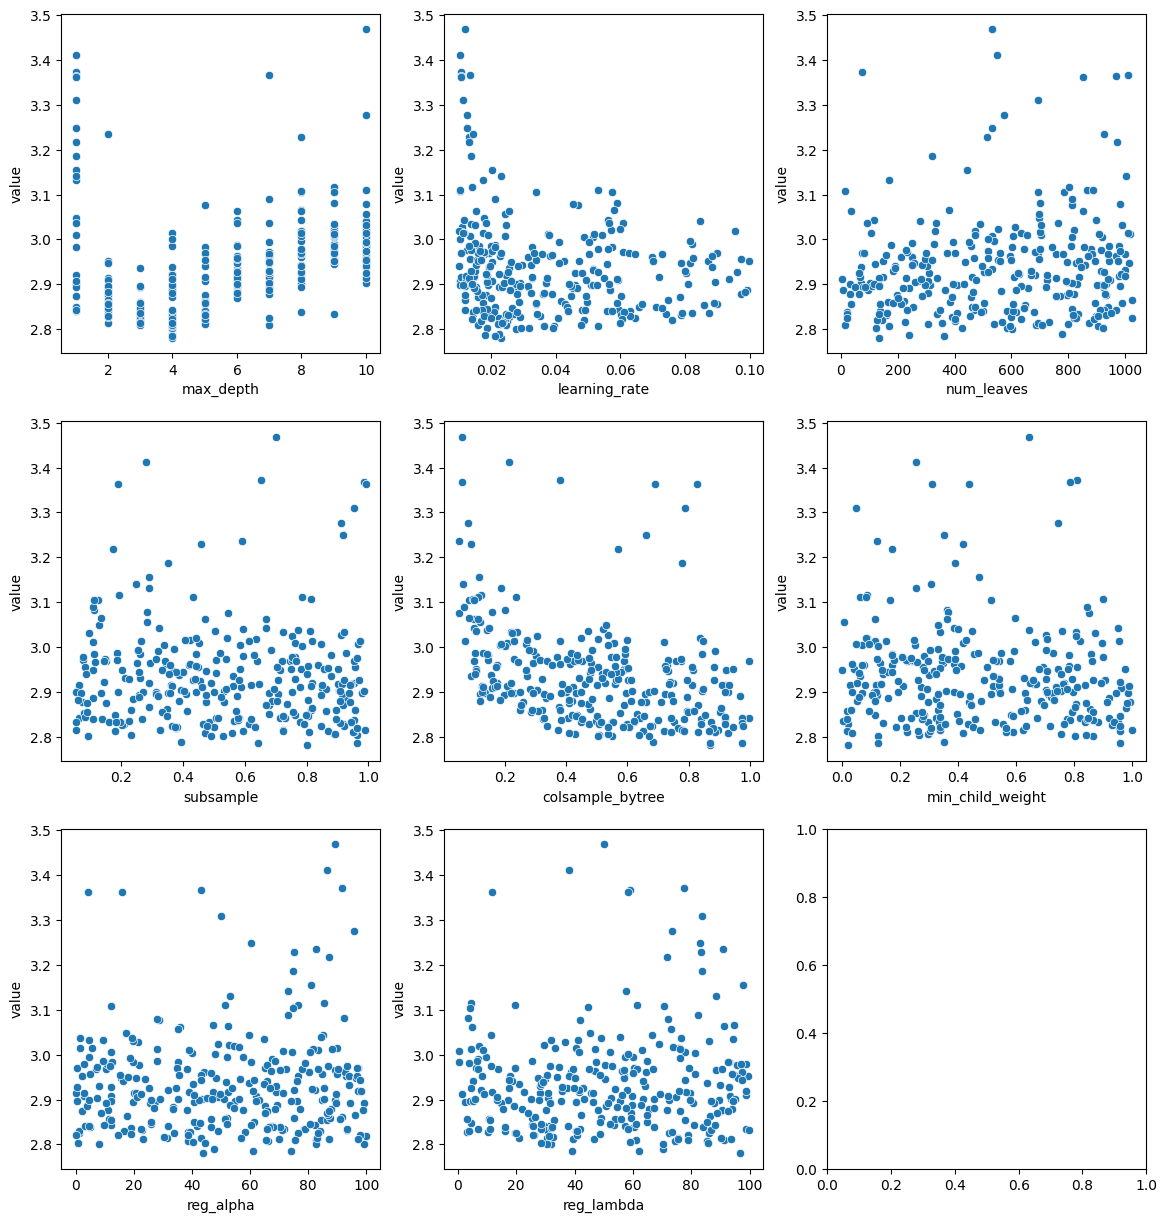

In [27]:
study_df = get_study_df("lightgbm_101_200_study")
params_value_viz(study_df)

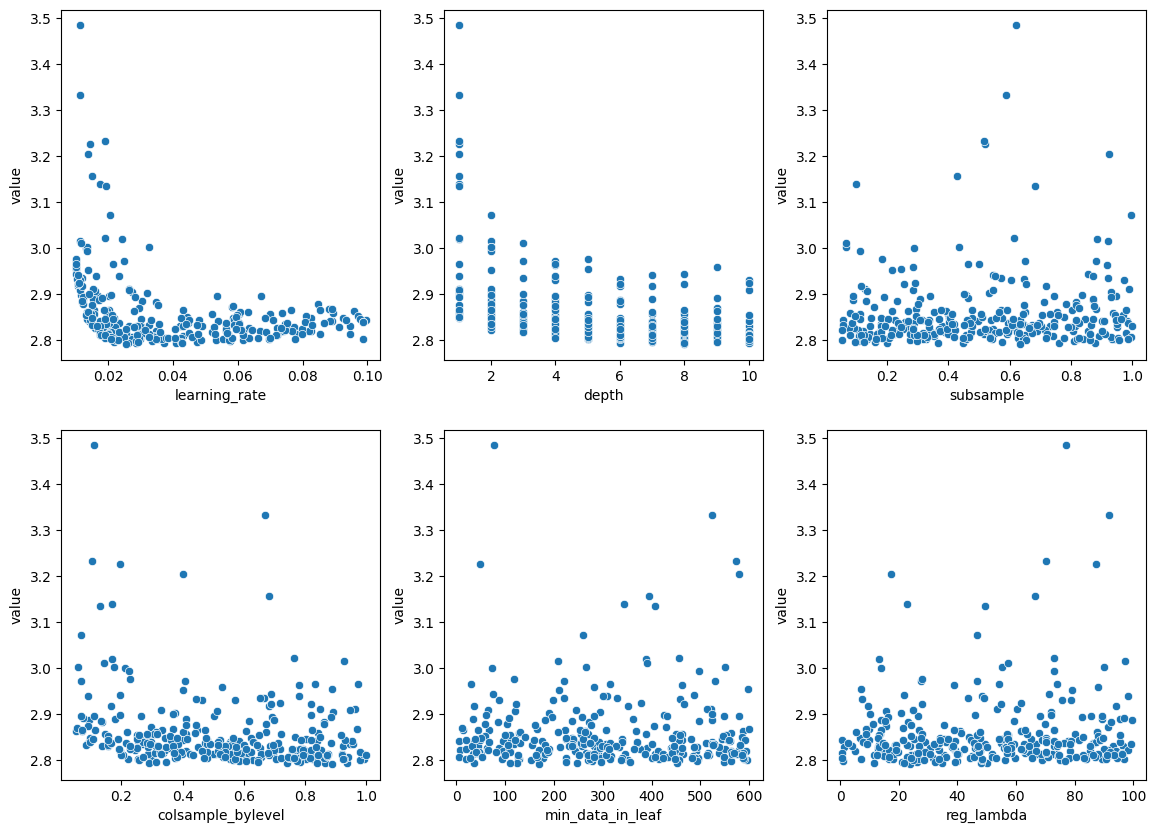

In [28]:
study_df = get_study_df("catboost_101_200_study")
params_value_viz(study_df)

Testing on best configuration

In [11]:
def get_best_params_from_file(filename):
    study = optuna.load_study(
        study_name = filename,
        storage = f"sqlite:///{filename}.db"
    )
    return study.best_params

In [ ]:
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = xgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

{'cod_prev_4': 0.4043276309967041,
 'cod_prev_4.5': 0.6704616472125053,
 'cod_prev_5': 0.628942608833313,
 'cod_prev_5.5': 0.752567708492279,
 'cod_prev_6': 0.24570008367300034,
 'cod_prev_6.5': 0.19465865939855576,
 'cod_prev_7': 0.13192889839410782,
 'cod_prev_7.5': 0.14080187678337097,
 'cod_prev_8': 0.43098312616348267,
 'cod_prev_8.5': 0.11375554464757442,
 'cod_prev_9': 0.04406125005334616,
 'cod_prev_9.5': 0.05807528551667929,
 'cod_prev_10': 0.05816362984478474,
 'cod_prev_10.5': 0.03658175468444824,
 'cod_prev_11': 0.06588049698621035,
 'cod_prev_11.5': 0.07855037599802017,
 'cod_prev_12': 0.08159683551639318,
 'temp_prev_4': 0.009340981487184763,
 'temp_prev_4.5': 0.01290007191710174,
 'temp_prev_5': 0.014045043266378343,
 'temp_prev_5.5': 0.018305073026567698,
 'temp_prev_6': 0.016320435563102365,
 'temp_prev_6.5': 0.010024440591223538,
 'temp_prev_7': 0.011234818957746029,
 'temp_prev_7.5': 0.012598840286955237,
 'temp_prev_8': 0.011362779303453863,
 'temp_prev_8.5': 0.0115

In [ ]:
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm = get_best_params_from_file(f"lightgbm_{default_random_state}_{default_n_trees}_study")
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = lgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# seems to pick up time features not as good as past 4 hours features

{'cod_prev_4': 3643,
 'cod_prev_4.5': 622,
 'cod_prev_5': 225,
 'cod_prev_5.5': 168,
 'cod_prev_6': 225,
 'cod_prev_6.5': 194,
 'cod_prev_7': 146,
 'cod_prev_7.5': 170,
 'cod_prev_8': 257,
 'cod_prev_8.5': 332,
 'cod_prev_9': 255,
 'cod_prev_9.5': 168,
 'cod_prev_10': 238,
 'cod_prev_10.5': 108,
 'cod_prev_11': 81,
 'cod_prev_11.5': 150,
 'cod_prev_12': 910,
 'temp_prev_4': 121,
 'temp_prev_4.5': 56,
 'temp_prev_5': 212,
 'temp_prev_5.5': 65,
 'temp_prev_6': 43,
 'temp_prev_6.5': 11,
 'temp_prev_7': 49,
 'temp_prev_7.5': 24,
 'temp_prev_8': 29,
 'temp_prev_8.5': 80,
 'temp_prev_9': 189,
 'temp_prev_9.5': 93,
 'temp_prev_10': 69,
 'temp_prev_10.5': 49,
 'temp_prev_11': 72,
 'temp_prev_11.5': 56,
 'temp_prev_12': 59,
 'ph_prev_4': 472,
 'ph_prev_4.5': 102,
 'ph_prev_5': 111,
 'ph_prev_5.5': 107,
 'ph_prev_6': 53,
 'ph_prev_6.5': 68,
 'ph_prev_7': 35,
 'ph_prev_7.5': 60,
 'ph_prev_8': 133,
 'ph_prev_8.5': 146,
 'ph_prev_9': 220,
 'ph_prev_9.5': 160,
 'ph_prev_10': 127,
 'ph_prev_10.5': 15

In [ ]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost = get_best_params_from_file(f"catboost_{default_random_state}_{default_n_trees}_study")
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = cbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# can pick up a combination of both past cod and tss, not good at picking up ph, temp

{'cod_prev_4': 219.38052437883425,
 'cod_prev_4.5': 48.711277455211864,
 'cod_prev_5': 22.330127962270083,
 'cod_prev_5.5': 16.58227518181197,
 'cod_prev_6': 8.647774879540293,
 'cod_prev_6.5': 5.649379808452873,
 'cod_prev_7': 6.253173311005719,
 'cod_prev_7.5': 7.466187811351683,
 'cod_prev_8': 6.653188863022914,
 'cod_prev_8.5': 7.895455134420382,
 'cod_prev_9': 5.668467006025644,
 'cod_prev_9.5': 5.765540684882319,
 'cod_prev_10': 5.869582630227189,
 'cod_prev_10.5': 3.985894206190639,
 'cod_prev_11': 5.316905218165675,
 'cod_prev_11.5': 6.610830716553982,
 'cod_prev_12': 13.693097597823598,
 'temp_prev_4': 1.19909213793197,
 'temp_prev_4.5': 0.6750365286984451,
 'temp_prev_5': 0.6607784027663385,
 'temp_prev_5.5': 1.0563869133697377,
 'temp_prev_6': 1.022560079255698,
 'temp_prev_6.5': 0.7286229144776952,
 'temp_prev_7': 0.9147733047404768,
 'temp_prev_7.5': 0.423902919948282,
 'temp_prev_8': 0.6899242538045945,
 'temp_prev_8.5': 1.171068141375584,
 'temp_prev_9': 1.04355825356684

Try to train with only previous CODs insteads

In [33]:
features_used = [f"cod_prev_{i}" for i in lag_used] 
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [38]:
best_params_xgboost_only_cod = optimize_xgboost(
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb",
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb",
)

[I 2025-06-09 20:02:12,955] Using an existing study with name 'xgboost_study_101_200_best_comb' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-06-09 20:02:19,818] Trial 203 finished with value: 2.8926364404527827 and parameters: {'max_depth': 4, 'learning_rate': 0.018472341838106907, 'subsample': 0.3266253118107859, 'colsample_bytree': 0.7200447709655037, 'colsample_bynode': 0.13685057088152586, 'colsample_bylevel': 0.18547982722138023, 'min_child_weight': 7, 'reg_alpha': 81.8487339276294, 'reg_lambda': 90.10181036144859, 'gamma': 4.164212908346122}. Best is trial 178 with value: 2.8267396434616847.
[I 2025-06-09 20:02:21,760] Trial 200 finished with value: 3.0269724386498282 and parameters: {'max_depth': 6, 'learning_rate': 0.06169429335383051, 'subsample': 0.5890153660048836, 'colsample_bytree': 0.05019734478808813, 'colsample_bynode': 0.742528252868185, 'colsample_bylevel': 0.6796891833849271, 'min_child_weight': 10, 'reg_alpha': 51.84638144483091, 'reg_lambda': 67.43741610355349, 'gamma': 2.633219796033215}. Best is trial 178 with value: 2.8267396434616847.
[I 2025-06-09 20:02:22,675] Trial 201 finished with value

Best hyperparameters: {'max_depth': 8, 'learning_rate': 0.02961899990653856, 'subsample': 0.06633305959836935, 'colsample_bytree': 0.7228437730105558, 'colsample_bynode': 0.7882513587098353, 'colsample_bylevel': 0.6446187284768308, 'min_child_weight': 7, 'reg_alpha': 50.54923137130809, 'reg_lambda': 29.802646376452834, 'gamma': 4.949878267136354}
Best RMSE: 2.8184642292474584


In [ ]:
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
best_params_xgboost_only_cod = get_best_params_from_file(f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_xgboost_only_cod:
    params[p] = best_params_xgboost_only_cod[p]

feature_importances = {}

xgbr = XGBRegressor(**params)
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr.fit(X_train, Y_train)
    features = xgbr.feature_names_in_.tolist()
    features_i = xgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances
# Seems like only COD features are important (can try to only use 4-8 hours if 4-13 hours does not work well)

{'cod_prev_4': 0.8793247640132904,
 'cod_prev_4.5': 1.0509153306484222,
 'cod_prev_5': 0.6796966344118118,
 'cod_prev_5.5': 0.4750918112695217,
 'cod_prev_6': 0.6888431459665298,
 'cod_prev_6.5': 0.3237054329365492,
 'cod_prev_7': 0.27738556265830994,
 'cod_prev_7.5': 0.13517510797828436,
 'cod_prev_8': 0.07341017480939627,
 'cod_prev_8.5': 0.09826207999140024,
 'cod_prev_9': 0.044852341525256634,
 'cod_prev_9.5': 0.051734684035182,
 'cod_prev_10': 0.03721222374588251,
 'cod_prev_10.5': 0.03688788926228881,
 'cod_prev_11': 0.041134904604405165,
 'cod_prev_11.5': 0.050618547946214676,
 'cod_prev_12': 0.05574914626777172}

In [12]:
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.5]] 
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [15]:
best_params_xgboost_only_cod = optimize_xgboost(
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_truncated",
    f"xgboost_study_{default_random_state}_{default_n_trees}_best_comb_truncated",
)

[I 2025-06-09 23:36:39,326] Using an existing study with name 'xgboost_study_101_200_best_comb_truncated' instead of creating a new one.


Conduct hyperparam opt for XGBoost


[I 2025-06-09 23:36:44,315] Trial 202 finished with value: 2.9037640775993907 and parameters: {'max_depth': 3, 'learning_rate': 0.034757747557211144, 'subsample': 0.7357685771612633, 'colsample_bytree': 0.4493019718882516, 'colsample_bynode': 0.08808509567419742, 'colsample_bylevel': 0.820075281032131, 'min_child_weight': 7, 'reg_alpha': 39.85190662105017, 'reg_lambda': 51.9008296680432, 'gamma': 3.340577613279343}. Best is trial 52 with value: 2.830214065997263.
[I 2025-06-09 23:36:46,901] Trial 200 finished with value: 2.896827216499804 and parameters: {'max_depth': 6, 'learning_rate': 0.05476267929615558, 'subsample': 0.06577363692939225, 'colsample_bytree': 0.2892575505380963, 'colsample_bynode': 0.6376463717682658, 'colsample_bylevel': 0.8955992587889161, 'min_child_weight': 6, 'reg_alpha': 56.35492575066906, 'reg_lambda': 89.774249848988, 'gamma': 2.3593840216214734}. Best is trial 52 with value: 2.830214065997263.
[I 2025-06-09 23:36:47,195] Trial 201 finished with value: 2.8887

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.024035616336322528, 'subsample': 0.09912930308348475, 'colsample_bytree': 0.8158110666537604, 'colsample_bynode': 0.6861075533161128, 'colsample_bylevel': 0.6288182237390194, 'min_child_weight': 7, 'reg_alpha': 10.937676304447752, 'reg_lambda': 99.08772059837091, 'gamma': 0.6665374219855152}
Best RMSE: 2.830214065997263


Try to using only some past hours cod and some non-cod features

In [19]:
# use 1 month for test and previous montsh for predict
# Take 1: only use features appear in all data
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 8.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)
# not really good, try to use an extended version

In [21]:
best_params_lightgbm_best_comb = optimize_lightgbm(
    f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb",
    f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb"
)

[I 2025-06-10 00:01:38,533] Using an existing study with name 'lightgbm_study_101_200_best_comb' instead of creating a new one.


Conduct hyperparam opt for LightGBM


[I 2025-06-10 00:01:44,507] Trial 100 finished with value: 2.807265641006368 and parameters: {'max_depth': 3, 'learning_rate': 0.06149265415436192, 'num_leaves': 874, 'subsample': 0.6812427784938845, 'colsample_bytree': 0.32752509716942063, 'min_child_weight': 0.5729984206976143, 'reg_alpha': 14.449932572677582, 'reg_lambda': 78.89681505208904}. Best is trial 25 with value: 2.7801137363485227.
[I 2025-06-10 00:01:47,098] Trial 103 finished with value: 2.9018398819495754 and parameters: {'max_depth': 4, 'learning_rate': 0.05485199520567838, 'num_leaves': 184, 'subsample': 0.09973827901134924, 'colsample_bytree': 0.07041949457421412, 'min_child_weight': 0.18992914234665226, 'reg_alpha': 78.75463244143663, 'reg_lambda': 80.8840619706889}. Best is trial 25 with value: 2.7801137363485227.
[I 2025-06-10 00:02:05,515] Trial 105 finished with value: 2.8663078203756385 and parameters: {'max_depth': 8, 'learning_rate': 0.058204710845400603, 'num_leaves': 25, 'subsample': 0.3944500619116234, 'col

Best hyperparameters: {'max_depth': 4, 'learning_rate': 0.01998148554659333, 'num_leaves': 446, 'subsample': 0.3938893819055116, 'colsample_bytree': 0.848909955828112, 'min_child_weight': 0.9990200369986556, 'reg_alpha': 88.07895155720773, 'reg_lambda': 37.139057496343334}
Best MSE: 2.7801137363485227


In [ ]:
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": default_random_state
}
best_params_lightgbm_best_comb = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_lightgbm_best_comb:
    params[p] = best_params_lightgbm_best_comb[p]

feature_importances = {}

lgbr = LGBMRegressor(**params)
for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    lgbr.fit(X_train, Y_train)
    features = lgbr.feature_names_in_.tolist()
    features_i = lgbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances

{'cod_prev_4': 4672,
 'cod_prev_4.5': 1223,
 'cod_prev_8.5': 1726,
 'cod_prev_12': 1780,
 'ph_prev_4': 2053,
 'tss_prev_4': 1763,
 'sin_day': 615,
 'sin_month': 992}

Try to look at special combination based on catboost

In [23]:
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]

X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

In [26]:
best_params_catboost_best_comb = optimize_catboost(
    f"catboost_study_{default_random_state}_{default_n_trees}_best_comb",
    f"catboost_study_{default_random_state}_{default_n_trees}_best_comb"
)

[I 2025-06-10 00:45:49,797] Using an existing study with name 'catboost_study_101_200_best_comb' instead of creating a new one.


Conduct hyperparam opt for CatBoost


[I 2025-06-10 00:45:57,706] Trial 202 finished with value: 2.80370521492425 and parameters: {'learning_rate': 0.029933401615847975, 'depth': 3, 'subsample': 0.5646816883114785, 'colsample_bylevel': 0.9482281043011349, 'min_data_in_leaf': 25, 'reg_lambda': 99.5539305489311}. Best is trial 80 with value: 2.726927756842718.
[I 2025-06-10 00:46:00,406] Trial 203 finished with value: 2.764885668313071 and parameters: {'learning_rate': 0.04076230288593556, 'depth': 6, 'subsample': 0.40966700488583596, 'colsample_bylevel': 0.332945945990768, 'min_data_in_leaf': 280, 'reg_lambda': 97.86219706179898}. Best is trial 80 with value: 2.726927756842718.
[I 2025-06-10 00:46:01,396] Trial 201 finished with value: 2.7589005653691356 and parameters: {'learning_rate': 0.044301885266327716, 'depth': 4, 'subsample': 0.8925382143333724, 'colsample_bylevel': 0.8621705419449194, 'min_data_in_leaf': 239, 'reg_lambda': 5.9777689632511954}. Best is trial 80 with value: 2.726927756842718.
[I 2025-06-10 00:46:04,1

Best hyperparameters: {'learning_rate': 0.03433343849180993, 'depth': 10, 'subsample': 0.917049714847064, 'colsample_bylevel': 0.9656725844669974, 'min_data_in_leaf': 598, 'reg_lambda': 23.12837275893057}
Best RMSLE: 2.726927756842718


In [32]:
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": default_random_state
}
best_params_catboost_best_comb = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
for p in best_params_catboost_best_comb:
    params[p] = best_params_catboost_best_comb[p]

feature_importances = {}

cbr = CatBoostRegressor(**params)
cv_rmse = 0

for i in range(5):
    X_train = X_train_arr[i]
    Y_train = Y_train_arr[i]
    cbr.fit(X_train, Y_train)
    features = cbr.feature_names_
    features_i = cbr.feature_importances_.tolist()
    for inx, feat in enumerate(features):
        feature_importances[feat] = feature_importances.get(feat, 0) + features_i[inx]

feature_importances

{'cod_prev_4': 179.08209075778728,
 'cod_prev_4.5': 41.660385243245294,
 'cod_prev_5': 20.812637991126657,
 'cod_prev_5.5': 17.89249746522793,
 'cod_prev_6': 8.376919474635294,
 'cod_prev_6.5': 6.542274953253839,
 'cod_prev_7': 5.9931256422575725,
 'cod_prev_7.5': 7.528693685073183,
 'cod_prev_8': 6.868403860720802,
 'cod_prev_8.5': 6.923453406768803,
 'cod_prev_9': 8.420862793305655,
 'cod_prev_9.5': 7.77924157076718,
 'cod_prev_10': 7.746537913270697,
 'cod_prev_10.5': 4.370450498945063,
 'cod_prev_11': 10.32574438327535,
 'cod_prev_11.5': 11.223413241906883,
 'cod_prev_12': 20.36086608145882,
 'sin_day': 31.83122296069932,
 'sin_month': 40.56783569726366,
 'tss_prev_4': 17.140072600720412,
 'tss_prev_4.5': 10.788585839198907,
 'tss_prev_5': 12.588065563372334,
 'tss_prev_5.5': 15.176618375719102}

Combine all 3 models

In [33]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

# train list of models
xgbr_arr = [XGBRegressor(**params)] * 5
Y_pred_xgboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    xgbr_arr[i].fit(X_train, Y_train)
    Y_pred_xgboost_arr.append(xgbr_arr[i].predict(X_test))

In [34]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 8.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_lightgbm = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": default_random_state
}
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

# train list of models
lgbr_arr = [LGBMRegressor(**params)] * 5
Y_pred_lightgbm_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    lgbr_arr[i].fit(X_train, Y_train)
    Y_pred_lightgbm_arr.append(lgbr_arr[i].predict(X_test))

In [35]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]
X_train_arr, X_test_arr, Y_train_arr, Y_test_arr = create_cv_split(df, features_used)

# get best model params
best_params_catboost = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": default_random_state
}
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

# train list of models
cbr_arr = [CatBoostRegressor(**params)] * 5
Y_pred_catboost_arr = []
for i in range(5):
    X_train, X_test = X_train_arr[i], X_test_arr[i]
    Y_train, Y_test = Y_train_arr[i], Y_test_arr[i]
    cbr_arr[i].fit(X_train, Y_train)
    Y_pred_catboost_arr.append(cbr_arr[i].predict(X_test))

In [36]:
best_cv_rmse = float("inf")
best_alpha = -1
best_beta = -1
for alpha in tqdm([0.01 * k for k in range(101)]):
    for beta in [0.01 * l for l in range(101)]:
        cv_rmse = 0
        for i in range(5):
            Y_pred =  alpha * Y_pred_catboost_arr[i] + (1 - alpha) * beta * Y_pred_lightgbm_arr[i] + (1 - alpha) * (1 - beta) * Y_pred_xgboost_arr[i]
            rmse = root_mean_squared_error(Y_test_arr[i], Y_pred)
            cv_rmse += rmse
        cv_rmse /= 5
        if cv_rmse < best_cv_rmse:
            best_cv_rmse = cv_rmse 
            best_alpha = alpha
            best_beta = beta
print(best_alpha, best_beta, best_cv_rmse)

100%|██████████| 101/101 [00:12<00:00,  8.30it/s]

0.81 1.0 2.723980762843719


Train model with best config on all data

In [28]:
def split(df, features_used):
    X = df[features_used]
    Y = df["cod"]
    return X, Y

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                [f"temp_prev_{i}" for i in lag_used] + \
                [f"ph_prev_{i}" for i in lag_used] + \
                [f"tss_prev_{i}" for i in lag_used] + \
                ["sin_hour", "sin_day", "sin_month"]
X, Y = split(df, features_used)

# get best model params
best_params_xgboost = get_best_params_from_file(f"xgboost_{default_random_state}_{default_n_trees}_study")
params = {
    "n_estimators": 200,
    "verbosity": 0,
    "enable_categorical": True,
    "random_state": default_random_state
}
for p in best_params_xgboost:
    params[p] = best_params_xgboost[p]

# train list of models
xgbr = XGBRegressor(**params)
xgbr.fit(X, Y)
with open(f'model/xgboost_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(xgbr, f)

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in [4, 4.5, 8.5, 12]] + \
                ["ph_prev_4", "tss_prev_4"] + \
                ["sin_day", "sin_month"]
X, Y = split(df, features_used)

# get best model params
best_params_lightgbm = get_best_params_from_file(f"lightgbm_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "n_estimators": 200,
    "verbosity": -1,
    "random_state": default_random_state
}
for p in best_params_lightgbm:
    params[p] = best_params_lightgbm[p]

# train list of models
lgbr = LGBMRegressor(**params)
lgbr.fit(X, Y)
with open(f'model/lightgbm_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(lgbr, f)

In [ ]:
# get dataframes for used
features_used = [f"cod_prev_{i}" for i in lag_used] + \
                ["sin_day", "sin_month"] + \
                ["tss_prev_4", "tss_prev_4.5", "tss_prev_5", "tss_prev_5.5"]
X, Y = split(df, features_used)

# get best model params
best_params_catboost = get_best_params_from_file(f"catboost_study_{default_random_state}_{default_n_trees}_best_comb")
params = {
    "iterations": 200,
    "verbose": False,
    "random_seed": default_random_state
}
for p in best_params_catboost:
    params[p] = best_params_catboost[p]

# train list of models
cbr = CatBoostRegressor(**params)
cbr.fit(X, Y)
with open(f'model/catboost_model_{default_random_state}_{default_n_trees}.pkl', 'wb') as f:
	pickle.dump(cbr, f)